In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB,ComplementNB,MultinomialNB,BernoulliNB,CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Loading the Data

In [2]:
store_info = pd.read_csv("/kaggle/input/data-storm-4/Store-info.csv")
transactions=pd.read_csv("/kaggle/input/data-storm-4/Historical-transaction-data.csv")
testing = pd.read_csv("/kaggle/input/data-storm-4/Testing-data.csv")
# transactions["transaction_date"]
# len(transactions[transactions["shop_id"] =="SHOP008"]["item_description"].unique())
transactions
store_info


,shop_id,shop_area_sq_ft,shop_profile
0,SHOP047,528,Moderate
1,SHOP009,676,High
2,SHOP083,676,Low
3,SHOP117,676,Low
4,SHOP042,676,Low
...,...,...,...
119,SHOP087,527,NaN
120,SHOP050,411,NaN
121,SHOP061,699,NaN
122,SHOP056,597,NaN


# Basic Feature Engineering and Seperating Training and Testing

In [3]:
#dropping the ones that are not necessaary for this stage
# transactions = transactions[['shop_id', 'item_price', 'quantity_sold']].copy()

#creating the income column 
transactions["income"] = transactions["item_price"]*transactions["quantity_sold"]
# transactions.head()

combined_data = store_info[['shop_id', 'shop_area_sq_ft']].copy()
combined_data['income']= combined_data["shop_id"].map(
    lambda key:transactions[transactions["shop_id"]==key]["income"].sum()
)
combined_data["quantity"]=combined_data["shop_id"].map(
    lambda key:transactions[transactions["shop_id"]==key]["quantity_sold"].sum()
)
combined_data["product_diversity"]=combined_data["shop_id"].map(
    lambda key:len(transactions[transactions["shop_id"] ==key]["item_description"].unique())
)
combined_data["customer_diversity"]=combined_data["shop_id"].map(
    lambda key:len(transactions[transactions["shop_id"] ==key]["customer_id"].unique())
)
combined_data = combined_data.rename(columns = {"shop_area_sq_ft":"area"})
combined_data["profile"] = store_info["shop_profile"].copy()
combined_data["income_per_area"]=combined_data["income"]/combined_data["area"]
combined_data["quantity_per_area"]=combined_data["quantity"]/combined_data["area"]
combined_data["products_per_area"]=combined_data["product_diversity"]/combined_data["area"]
combined_data["number_of_transactions"] = combined_data["shop_id"].map(
    lambda key:len(transactions[transactions["shop_id"] ==key])
)/combined_data["area"]
print(combined_data["number_of_transactions"].sum())
combined_data


791.8345572731404


,shop_id,area,income,quantity,product_diversity,customer_diversity,profile,income_per_area,quantity_per_area,products_per_area,number_of_transactions
0,SHOP047,528,842960,3288,36,928,Moderate,1596.515152,6.227273,0.068182,3.204545
1,SHOP009,676,1970870,8411,36,2498,High,2915.488166,12.442308,0.053254,6.788462
2,SHOP083,676,1691985,6644,37,1900,Low,2502.936391,9.828402,0.054734,5.346154
3,SHOP117,676,2325980,8073,36,2037,Low,3440.798817,11.942308,0.053254,6.026627
4,SHOP042,676,1340215,5844,36,1841,Low,1982.566568,8.644970,0.053254,4.840237
...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,1128935,3750,36,1083,NaN,2142.191651,7.115750,0.068311,3.855787
120,SHOP050,411,2399125,7668,32,1778,NaN,5837.287105,18.656934,0.077859,9.559611
121,SHOP061,699,2110800,6053,36,1746,NaN,3019.742489,8.659514,0.051502,4.464950
122,SHOP056,597,3023805,11163,36,2832,NaN,5065.000000,18.698492,0.060302,9.651591


In [4]:
# Seprating Training and Testing
training_data = combined_data[~combined_data["profile"].isnull()].copy()
testing_data = combined_data[combined_data["profile"].isnull()].copy()


In [5]:
#Remapping profiles to numbers
LOW = 0
MODERATE = 1
HIGH = 2
PREDICTION_CLASSES = [LOW,MODERATE,HIGH]
# Basic Feaure Names
ID = "shop_id"
PROFILE = "profile"
QUANTITY = "quantity"
INCOME = "income"
AREA = "area"
PRODUCT_DIVERSITY = "product_diversity"
CUSTOMER_DIVERSITY = "customer_diversity"
INCOME_PER_AREA = "income_per_area"
QUANTITY_PER_AREA = "quantity_per_area"
PRODUCTS_PER_AREA = "products_per_area"
NUMBER_OF_TRANSACTIONS = "number_of_transactions"
IP_TO_SP = {
    LOW:"Low",
    MODERATE:"Moderate",
    HIGH:"High"
}

SP_TO_IP = {value:key for key,value in IP_TO_SP.items()}
def iprofile_to_sprofile(iprofile:int):
    return IP_TO_SP[iprofile]
def sprofile_to_iprofile(sprofile:str):
    return SP_TO_IP[sprofile]

training_data['profile'] = training_data['profile'].map(sprofile_to_iprofile)
training_data.head()

,shop_id,area,income,quantity,product_diversity,customer_diversity,profile,income_per_area,quantity_per_area,products_per_area,number_of_transactions
0,SHOP047,528,842960,3288,36,928,1,1596.515152,6.227273,0.068182,3.204545
1,SHOP009,676,1970870,8411,36,2498,2,2915.488166,12.442308,0.053254,6.788462
2,SHOP083,676,1691985,6644,37,1900,0,2502.936391,9.828402,0.054734,5.346154
3,SHOP117,676,2325980,8073,36,2037,0,3440.798817,11.942308,0.053254,6.026627
4,SHOP042,676,1340215,5844,36,1841,0,1982.566568,8.644970,0.053254,4.840237


# Visual Analysis of Data

In [6]:
low_data = training_data[training_data[PROFILE]==LOW]
moderate_data = training_data[training_data[PROFILE]==MODERATE]
high_data = training_data[training_data[PROFILE]==HIGH]

<AxesSubplot:>

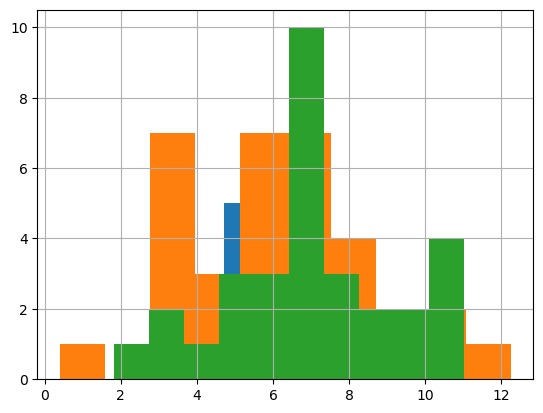

In [7]:
#area
feature = NUMBER_OF_TRANSACTIONS
low_data[feature].hist()
# plt.show()
moderate_data[feature].hist()
# plt.show()
high_data[feature].hist()
# plt.show()

## Feature Vector Creation

In [8]:
def create_feature_vectors(df,features,prediction_name=None,normalization_parameters=None,normalize=True):
    #returns feature vector array and predictions if prediction_name is given
    df = df.copy() #creating a local copy
    #calculating normalization paramteres if they are not provided
    
    if(normalization_parameters is None):
        print("************************************")
        print("Caclulating normalizing paramters!!!")
        print("************************************")
        normalization_parameters = {feature:(df[feature].mean(),df[feature].std()) for feature in features}
    
    #normalizing according to the paramters
    if(normalize):
        for feature in features:
            mean,std = normalization_parameters[feature]
            df[feature] = (df[feature] - mean)/std
        
    feature_vectors = np.stack([df[feature].to_numpy() for feature in features],axis=1)
    if(prediction_name is None):
        return feature_vectors,normalization_parameters,None
    return feature_vectors,normalization_parameters,df[prediction_name].to_numpy()   

In [9]:
data = training_data
# data= training_data.head()
feature_vectors,normalization_parameters,ground_truth = create_feature_vectors(df=data,features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=PROFILE,normalize=True)

************************************
Caclulating normalizing paramters!!!
************************************


# Functions for evaluvations

In [10]:
def create_confusion_matrix(ground_truth,predictions,features):
    n_features = len(features)
    confusion_matrix = np.zeros((n_features,n_features))
    for index1,f1 in enumerate(features):
        for index2,f2 in enumerate(features):
            confusion_matrix[index1,index2] = np.sum((ground_truth == f1) & (predictions == f2))
    assert(len(predictions) == len(ground_truth) and len(predictions) == np.sum(confusion_matrix))
    return confusion_matrix/np.sum(confusion_matrix)
    

# Trying Out Basic Classification Methods

# Support Vector Machines

In [11]:
def try_out_svm(kernel):
    classifire = svm.SVC(kernel=kernel)
    classifire.fit(feature_vectors,ground_truth)
    predictions = classifire.predict(feature_vectors)
    confusion_matrix = create_confusion_matrix(ground_truth,predictions,[0,1,2])
    score = f1_score(y_true=ground_truth,y_pred=predictions,labels=PREDICTION_CLASSES,average='macro')
    return confusion_matrix,score,classifire

In [12]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_svm = None
best_score = -1
for kernel in kernels:
    print(f"************Trying out kernel = {kernel}******************")
    cm,score,cla = try_out_svm(kernel)
    if(best_score < score):
        best_svm = cla
        best_score = score
    print(cm)
    print(f"f1 score:{score}")
    print(f"**********************************************************")

************Trying out kernel = linear******************
[[0.22 0.08 0.06]
 [0.05 0.23 0.05]
 [0.04 0.02 0.25]]
f1 score:0.6999849238655208
**********************************************************
************Trying out kernel = poly******************
[[0.35 0.   0.01]
 [0.19 0.14 0.  ]
 [0.16 0.   0.15]]
f1 score:0.6314733038940185
**********************************************************
************Trying out kernel = rbf******************
[[0.27 0.06 0.03]
 [0.05 0.24 0.04]
 [0.06 0.02 0.23]]
f1 score:0.7407632096156687
**********************************************************
************Trying out kernel = sigmoid******************
[[0.26 0.05 0.05]
 [0.18 0.08 0.07]
 [0.05 0.05 0.21]]
f1 score:0.5272467320261438
**********************************************************


# Naive Bayes

In [13]:
algos = {
    "Gaussian":GaussianNB,
#     "Multinomial":MultinomialNB,
#     "Complement":ComplementNB,
    "Bernouli":BernoulliNB,
#     "Categorial":CategoricalNB
}
best_naive = None
best_score = -1
for name,algo in algos.items():
    print(f"***************************{name}*******************************")
    classifire_gnb = algo()
    classifire_gnb.fit(feature_vectors,ground_truth)
    predictions = classifire_gnb.predict(feature_vectors)
    confusion_matrix = create_confusion_matrix(ground_truth,predictions,[0,1,2])
    score = f1_score(y_true=ground_truth,y_pred=predictions,labels=PREDICTION_CLASSES,average='macro')
    if(score > best_score):
        best_naive = classifire_gnb
        best_score = score
    print(confusion_matrix)
    print(score)
    print("****************************************************************")

***************************Gaussian*******************************
[[0.28 0.04 0.04]
 [0.13 0.14 0.06]
 [0.06 0.01 0.24]]
0.6505406240346
****************************************************************
***************************Bernouli*******************************
[[0.24 0.03 0.09]
 [0.17 0.07 0.09]
 [0.05 0.01 0.25]]
0.5264077825053435
****************************************************************


# KNN

In [14]:
classifire_knn = KNeighborsClassifier(n_neighbors=3)
classifire_knn.fit(feature_vectors,ground_truth)
predictions = classifire_knn.predict(feature_vectors)
confusion_matrix = create_confusion_matrix(ground_truth,predictions,[0,1,2])
score = f1_score(y_true=ground_truth,y_pred=predictions,labels=PREDICTION_CLASSES,average='macro')
print(confusion_matrix)
print(score)

[[0.32 0.03 0.01]
 [0.06 0.27 0.  ]
 [0.05 0.03 0.23]]
0.8215573456079786


# Ada Boost

In [15]:
from sklearn.ensemble import AdaBoostClassifier
classifire_adb = AdaBoostClassifier()
classifire_adb.fit(feature_vectors,ground_truth)
predictions = classifire_adb.predict(feature_vectors)
confusion_matrix = create_confusion_matrix(ground_truth,predictions,[0,1,2])
score = f1_score(y_true=ground_truth,y_pred=predictions,labels=PREDICTION_CLASSES,average='macro')
print(confusion_matrix)
print(score)

[[0.28 0.06 0.02]
 [0.05 0.27 0.01]
 [0.04 0.04 0.23]]
0.7818564676531512


# Gaussian Process

In [16]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
classifire_gau = GaussianProcessClassifier(1.0 * RBF(1.0))
classifire_gau.fit(feature_vectors,ground_truth)
predictions = classifire_gau.predict(feature_vectors)
confusion_matrix = create_confusion_matrix(ground_truth,predictions,[0,1,2])
score = f1_score(y_true=ground_truth,y_pred=predictions,labels=PREDICTION_CLASSES,average='macro')
print(confusion_matrix)
print(score)

[[0.28 0.06 0.02]
 [0.06 0.23 0.04]
 [0.06 0.03 0.22]]
0.730099041606624


# sklearn neuralnet

In [17]:
from sklearn.neural_network import MLPClassifier
classifire_nn = MLPClassifier(hidden_layer_sizes=(100,100,100),alpha=1, max_iter=1000)
classifire_nn.fit(feature_vectors,ground_truth)
predictions = classifire_nn.predict(feature_vectors)
confusion_matrix = create_confusion_matrix(ground_truth,predictions,[0,1,2])
score = f1_score(y_true=ground_truth,y_pred=predictions,labels=PREDICTION_CLASSES,average='macro')
print(confusion_matrix)
print(score)

[[0.36 0.   0.  ]
 [0.   0.33 0.  ]
 [0.02 0.01 0.28]]
0.9690667140705086


# Decision Tree

In [18]:
classifire_tree = DecisionTreeClassifier()
classifire_tree.fit(feature_vectors,ground_truth)
predictions = classifire_tree.predict(feature_vectors)
confusion_matrix = create_confusion_matrix(ground_truth,predictions,[0,1,2])
score = f1_score(y_true=ground_truth,y_pred=predictions,labels=PREDICTION_CLASSES,average='macro')
print(confusion_matrix)
print(score)

[[0.36 0.   0.  ]
 [0.   0.33 0.  ]
 [0.   0.   0.31]]
1.0


In [19]:
classifire_forest = RandomForestClassifier()
classifire_forest.fit(feature_vectors,ground_truth)
predictions = classifire_forest.predict(feature_vectors)
confusion_matrix = create_confusion_matrix(ground_truth,predictions,[0,1,2])
score = f1_score(y_true=ground_truth,y_pred=predictions,labels=PREDICTION_CLASSES,average='macro')
print(confusion_matrix)
print(score)

[[0.36 0.   0.  ]
 [0.   0.33 0.  ]
 [0.   0.   0.31]]
1.0


# Evaluvating the test data set

In [20]:
testing_data.head()

,shop_id,area,income,quantity,product_diversity,customer_diversity,profile,income_per_area,quantity_per_area,products_per_area,number_of_transactions
100,SHOP046,545,2607865,6941,36,1736,NaN,4785.073394,12.735780,0.066055,6.308257
101,SHOP024,676,1308795,5274,36,1641,NaN,1936.087278,7.801775,0.053254,4.264793
102,SHOP023,617,2570425,7946,37,2227,NaN,4166.004862,12.878444,0.059968,6.649919
103,SHOP097,310,2642380,6934,32,1669,NaN,8523.806452,22.367742,0.103226,10.154839
104,SHOP044,715,1310440,4965,36,1552,NaN,1832.783217,6.944056,0.050350,3.693706


,shop_id,area,income,quantity,product_diversity,customer_diversity,profile,income_per_area,quantity_per_area,products_per_area,number_of_transactions
100,SHOP046,545,2607865,6941,36,1736,Moderate,4785.073394,12.735780,0.066055,6.308257
101,SHOP024,676,1308795,5274,36,1641,Low,1936.087278,7.801775,0.053254,4.264793
102,SHOP023,617,2570425,7946,37,2227,Low,4166.004862,12.878444,0.059968,6.649919
103,SHOP097,310,2642380,6934,32,1669,Moderate,8523.806452,22.367742,0.103226,10.154839
104,SHOP044,715,1310440,4965,36,1552,Moderate,1832.783217,6.944056,0.050350,3.693706
105,SHOP030,530,2862995,7687,36,1637,Moderate,5401.877358,14.503774,0.067925,6.822642
106,SHOP038,411,1444025,5728,32,1781,Low,3513.442822,13.936740,0.077859,7.630170
107,SHOP029,597,1973805,7352,36,2052,Low,3306.206030,12.314908,0.060302,6.363484
108,SHOP096,676,2600915,9049,36,2497,High,3847.507396,13.386095,0.053254,7.100592
109,SHOP092,617,1961240,7266,36,2247,Low,3178.670989,11.776337,0.058347,6.343598


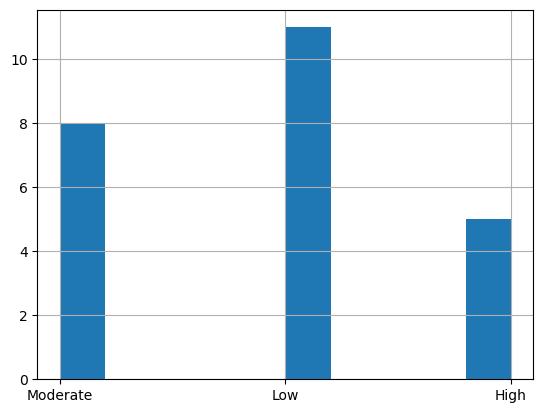

In [21]:
data = testing_data.copy()
# data= training_data.head()
test_feature_vectors,normalization_parameters,_ = create_feature_vectors(df=data,features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
profile_predictions =classifire_nn.predict(test_feature_vectors)
copy_testing = testing.copy()
copy_testing['shop_profile'] = list(map(iprofile_to_sprofile,profile_predictions,))
copy_testing['shop_profile'].hist()
data['profile']=copy_testing['shop_profile'].rename(index=lambda x : x+100)
plt.plot()
copy_testing
data

In [22]:
copy_testing.to_csv("/kaggle/working/per_area_feautures_forest_2_predictions.csv",index=False)

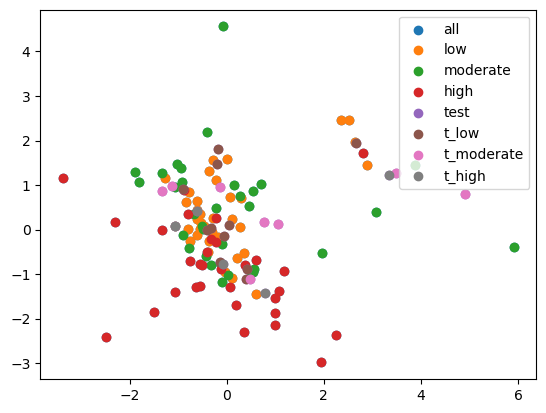

In [23]:
from sklearn.decomposition import PCA
redu = PCA(n_components=2)
redu.fit(feature_vectors)
dmrf = redu.transform(feature_vectors)
lfv,_,_ = create_feature_vectors(df=low_data,features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
mfv,_,_ = create_feature_vectors(df=moderate_data,features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
hfv,_,_ = create_feature_vectors(df=high_data,features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
rlfv = redu.transform(lfv)
rmfv = redu.transform(mfv)
rhfv = redu.transform(hfv)
rtfv = redu.transform(test_feature_vectors)
tlfv,_,_ = create_feature_vectors(df=data[data['profile']=="Low"],features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
tmfv,_,_ = create_feature_vectors(df=data[data['profile']=="Moderate"],features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
thfv,_,_ = create_feature_vectors(df=data[data['profile']=="High"],features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
trlfv = redu.transform(tlfv)
trmfv = redu.transform(tmfv)
trhfv = redu.transform(thfv)
plt.scatter(dmrf[:,0],dmrf[:,1],label="all")
plt.scatter(rlfv[:,0],rlfv[:,1],label="low")
plt.scatter(rmfv[:,0],rmfv[:,1],label="moderate")
plt.scatter(rhfv[:,0],rhfv[:,1],label="high")
plt.scatter(rtfv[:,0],rtfv[:,1],label="test")
plt.scatter(trlfv[:,0],trlfv[:,1],label="t_low")
plt.scatter(trmfv[:,0],trmfv[:,1],label="t_moderate")
plt.scatter(trhfv[:,0],trhfv[:,1],label="t_high")
plt.legend()
# plt.xlim(-6,  6)
# plt.ylim(-6, 6)
plt.show()
plt.show()

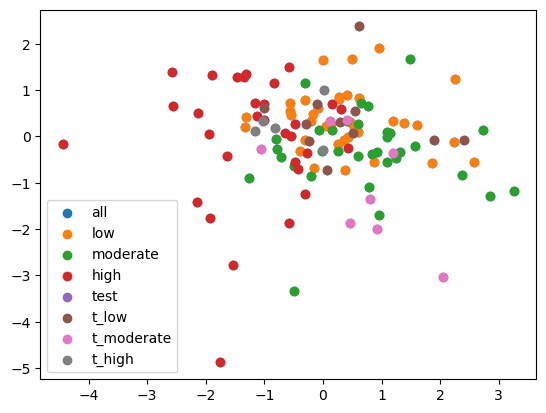

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
redu = LinearDiscriminantAnalysis()
redu.fit(feature_vectors,predictions)
dmrf = redu.transform(feature_vectors)
lfv,_,_ = create_feature_vectors(df=low_data,features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
mfv,_,_ = create_feature_vectors(df=moderate_data,features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
hfv,_,_ = create_feature_vectors(df=high_data,features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
rlfv = redu.transform(lfv)
rmfv = redu.transform(mfv)
rhfv = redu.transform(hfv)
rtfv = redu.transform(test_feature_vectors)
tlfv,_,_ = create_feature_vectors(df=data[data['profile']=="Low"],features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
tmfv,_,_ = create_feature_vectors(df=data[data['profile']=="Moderate"],features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
thfv,_,_ = create_feature_vectors(df=data[data['profile']=="High"],features=(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
trlfv = redu.transform(tlfv)
trmfv = redu.transform(tmfv)
trhfv = redu.transform(thfv)
plt.scatter(dmrf[:,0],dmrf[:,1],label="all")
plt.scatter(rlfv[:,0],rlfv[:,1],label="low")
plt.scatter(rmfv[:,0],rmfv[:,1],label="moderate")
plt.scatter(rhfv[:,0],rhfv[:,1],label="high")
plt.scatter(rtfv[:,0],rtfv[:,1],label="test")
plt.scatter(trlfv[:,0],trlfv[:,1],label="t_low")
plt.scatter(trmfv[:,0],trmfv[:,1],label="t_moderate")
plt.scatter(trhfv[:,0],trhfv[:,1],label="t_high")
plt.legend()
# plt.xlim(-6,  6)
# plt.ylim(-6, 6)
plt.show()
plt.show()

In [25]:
predictions = redu.predict(feature_vectors)
confusion_matrix = create_confusion_matrix(ground_truth,predictions,[0,1,2])
score = f1_score(y_true=ground_truth,y_pred=predictions,labels=PREDICTION_CLASSES,average='macro')
print(confusion_matrix)
print(score)

[[0.26 0.07 0.03]
 [0.09 0.19 0.05]
 [0.05 0.02 0.24]]
0.6896887026308942
